# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [1]:
from datetime import date
import pandas as pd
import mysql.connector
pd.options.mode.chained_assignment = None

from IPython.display import display, Markdown, HTML


display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-06-16

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

#display(getSubjectFromUuid(127338))
#display(getSubjectFromUuid(63496))
#display(getSubjectFromUuid(1))
#display(getSubjectFromUuid(170741))
#display(getSubjectFromUuid(167497))

In [3]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""));

In [4]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(100)

/tmp/ipykernel_133809/2145643300.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
...,...,...,...,...,...
252503,121732,2019-01-04 16:48:53,Jonathan,127576,Mathe
252505,121732,2019-01-04 16:49:01,Jonathan,127602,Mathe
252510,95854,2019-01-04 16:50:43,markus_janker,127600,Chemie


In [5]:
#Activation Rate pro Fach

def calc_activation_rates(days, edits, baseline):
    subject_list = list(filter(None, list(event_log['subject'].unique())))
    rates_df = pd.DataFrame(columns = ['subject', 'activation_rate', 'loss_rate'])

    for subject in subject_list:
        between_df = pd.DataFrame()
        activation_rate = int()
        loss_rate = int()
        for month in range(0,2):

            lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
            upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
            df1 = pd.DataFrame()
            df2 = pd.DataFrame()
            df3 = pd.DataFrame()
            df4 = pd.DataFrame()
            df5 = pd.DataFrame()

            df1 = event_log[lower_date < event_log['date']] 
            df2 = df1[df1['date'] < upper_date]
            df3 = df2[df2['subject'] == subject]
            df4 = df3.groupby(by = ['actor_id', 'username', 'subject'], as_index = False).count()
            #Delete all authors under baseline
            df5 = df4[df4['uuid']>= baseline]
            df5['isActive'] = df5['uuid'].apply(lambda x: 1 if x >= edits else 0)

            if between_df.empty:
                between_df = df5
            else:
                between_df = pd.merge(between_df, df5[['actor_id', 'isActive']], on=["actor_id"])

        if not between_df.empty and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
            between_df['change'] = between_df['isActive_x'] - between_df['isActive_y']
            activation_rate = between_df['change'][between_df['change']>0].sum() / len(between_df)
            loss_rate = between_df['change'][between_df['change']<0].sum() / len(between_df)
        else:
            continue
        append_srs = pd.Series([subject, round(activation_rate,2), round(loss_rate, 2)], index = rates_df.columns)
        rates_df = rates_df.append(append_srs, ignore_index=True)
    return rates_df
        

In [6]:
display(Markdown(f"### Aktivierungsrate pro Fach: Nicht aktive zu aktiven AutorInnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=10, baseline = 0)

### Aktivierungsrate pro Fach: Nicht aktive zu aktiven AutorInnen

Edits: 10, im Zeitraum: Letzte 90 Tage

/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.app

,subject,activation_rate,loss_rate
0,Chemie,0.00,0.00
1,Mathe,0.03,0.00
2,Testbereich!,0.05,-0.24
3,Englisch,0.00,0.00
4,Nachhaltigkeit,0.00,-0.12
5,Community,0.08,-0.08
6,Physik,0.00,-0.50
7,Prüfungsbereich Mathematik,0.00,0.00
8,Lerntipps,0.00,-0.50
9,Informatik,0.00,0.00


In [7]:
display(Markdown(f"### Aktivierungsrate pro Fach: Aktive zu mittelaktiven Autorinnen"))
display(Markdown(f"Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=50, baseline=10)

### Aktivierungsrate pro Fach: Aktive zu mittelaktiven Autorinnen

Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage

/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_133809/4253580534.py:41: FutureWarning: The frame.app

,subject,activation_rate,loss_rate
0,Mathe,0.08,-0.25
1,Testbereich!,0.33,0.00
2,Englisch,0.00,0.00
3,Nachhaltigkeit,0.00,-0.33
4,Community,0.00,0.00
5,Prüfungsbereich Mathematik,0.14,0.00
6,Informatik,0.00,0.00
7,Biologie,0.00,0.00
8,Math,0.00,0.00
9,Politik,0.00,0.00


In [8]:
#Activation Rate über alle Fächer hinweg

def calc_act_rates_wo_subj(days, edits, baseline):
    result_df = pd.DataFrame()

    for month in range(0,2):

        lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
        upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()
        df3 = pd.DataFrame()

        df1 = event_log[lower_date < event_log['date']] 
        df2 = df1[df1['date'] < upper_date]
        df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
        #Delete all authors under baseline
        df4 = df3[df3['uuid']>= baseline]
        df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)

        if result_df.empty:
            result_df = df4
        else:
            result_df = pd.merge(result_df, df4[['actor_id', 'isActive']], on=["actor_id"])

    if not result_df.empty: #and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
        result_df['change'] = result_df['isActive_x'] - result_df['isActive_y']
        activation_rate = result_df['change'][result_df['change']>0].sum() / len(result_df)
        loss_rate = result_df['change'][result_df['change']<0].sum() / len(result_df)
        
    return activation_rate, loss_rate

In [9]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: Nicht aktive zu aktiven Autorinnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(days=90, edits=10, baseline=0)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(days=90, edits=10, baseline=0)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: Nicht aktive zu aktiven Autorinnen

Edits: 10, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.03

Verlustrate: -0.03

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [10]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: von aktiven zu mittelaktiven AutorInnen"))
display(Markdown(f"Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(days=90, edits=50, baseline=10)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(days=90, edits=50, baseline=10)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: von aktiven zu mittelaktiven AutorInnen

Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.13

Verlustrate: -0.07

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [11]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    edits_per_day = compute_edits_per_day_per_user(df)
    df = edits_per_day.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit aktuellen Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Verlorene Autor:innen mit aktuellen Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind)"))
    df3 = edits_per_day.cumsum()
    df3 = pd.DataFrame({
        "edits": df3.loc[df.index[-1]],
        "edits_before": df3.loc[df.index[-1-time_interval]],
    })
    d = df3[(df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind) + Edits < {lower}"))
    d = df3[(df3["edits"] < lower) & (df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()     # This should probably be set to today!
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

#show()

### Plot Anzahl Autor:innen mit Edits >= 10

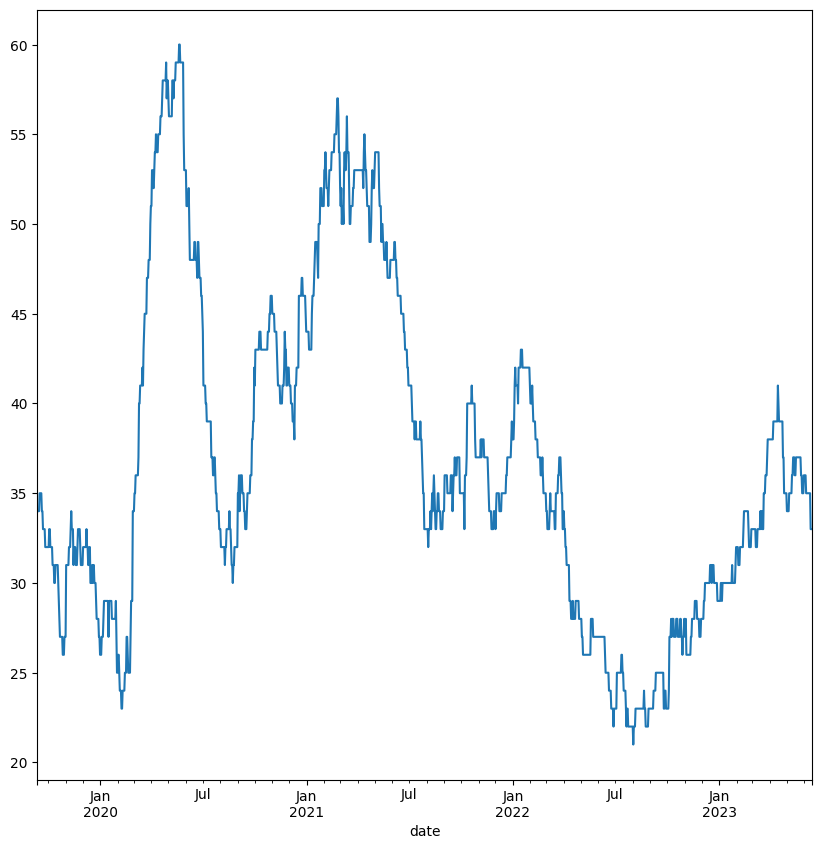

Anzahl Autor:innen mit Edits >= 10: 33

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,832.0
Kowalsky,430.0
Sascha_Lill_95,409.0
Nadine_Gabel,284.0
Karin,268.0
metzgaria,203.0
Peter,123.0
Julian1492,92.0
Corinna,84.0
AndiSt,72.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
dal,6.0
Leticia,6.0
sahara91,5.0
kathongi,2.0
Gesine,2.0
Carina,2.0
MaxHerzog,1.0
Paul_,0.0
wendrock,0.0
uebermario,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
KlausB,63.0
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
atmflow,5.0
AnnaTichs,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Adam09,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Yummy,6.0
AnnaTichs,5.0
atmflow,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
a-pong,3.0
Par145qv,3.0
Adam09,3.0
lejla,2.0


In [12]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

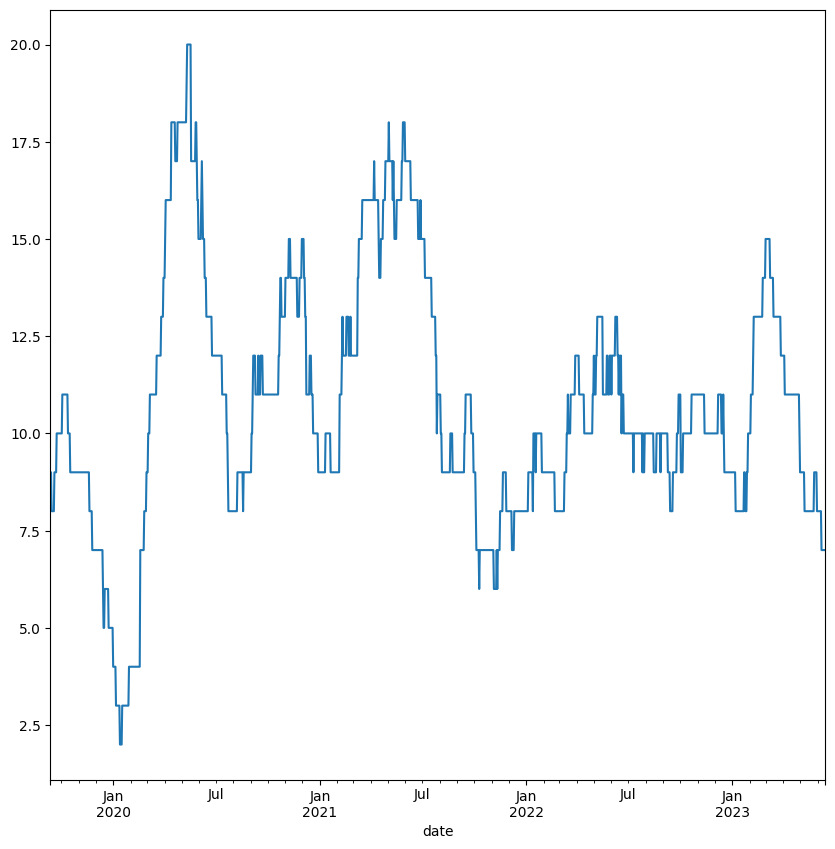

Anzahl Autor:innen mit Edits >= 100: 7

### Autor:innen mit aktuellen Edits >= 100

,edits
Felix_Eccardt,832.0
Kowalsky,430.0
Sascha_Lill_95,409.0
Nadine_Gabel,284.0
Karin,268.0
metzgaria,203.0
Peter,123.0


### Verlorene Autor:innen mit aktuellen Edits < 100 und vorher Edits >= 100

,edits
Corinna,84.0
BerndF,66.0
LinaMaria,44.0
Tina_B,22.0
Alexandra-Wolfram,22.0
uebermario,0.0
Gerlinger,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
KlausB,63.0
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
atmflow,5.0
AnnaTichs,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Adam09,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 100

,edits
KlausB,63.0
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
atmflow,5.0
AnnaTichs,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Adam09,3.0


In [13]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

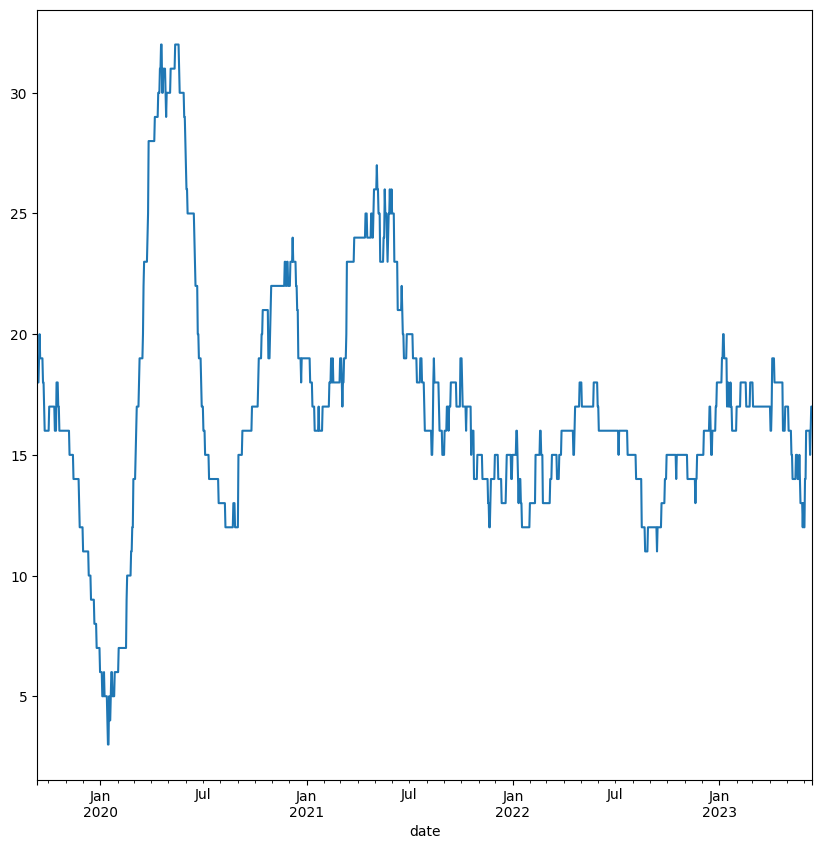

Anzahl Autor:innen mit Edits >= 50: 17

### Autor:innen mit aktuellen Edits >= 50

,edits
Felix_Eccardt,832.0
Kowalsky,430.0
Sascha_Lill_95,409.0
Nadine_Gabel,284.0
Karin,268.0
metzgaria,203.0
Peter,123.0
Julian1492,92.0
Corinna,84.0
AndiSt,72.0


### Verlorene Autor:innen mit aktuellen Edits < 50 und vorher Edits >= 50

,edits
LinaMaria,44.0
konstanze,40.0
hwlang,24.0
Tina_B,22.0
Alexandra-Wolfram,22.0
wendrock,0.0
uebermario,0.0
Gerlinger,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
KlausB,63.0
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
atmflow,5.0
AnnaTichs,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Adam09,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 50

,edits
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
AnnaTichs,5.0
atmflow,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Par145qv,3.0
a-pong,3.0


In [14]:
show(lower=50)

### Plot Anzahl Autor:innen mit Edits >= 1

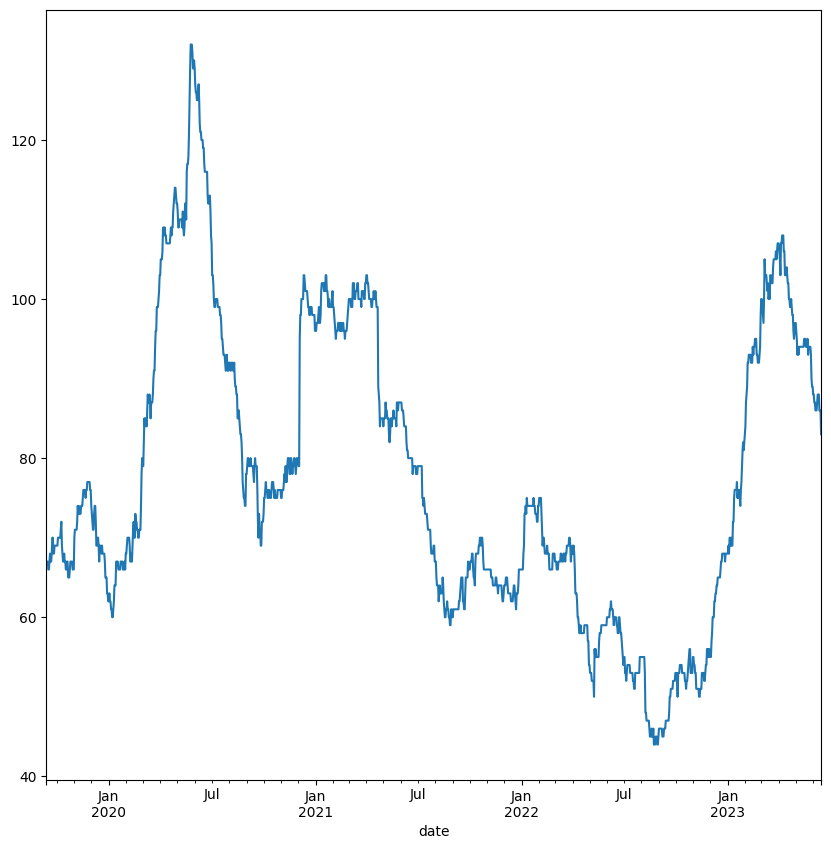

Anzahl Autor:innen mit Edits >= 1: 83

### Autor:innen mit aktuellen Edits >= 1

,edits
Felix_Eccardt,832.0
Kowalsky,430.0
Sascha_Lill_95,409.0
Nadine_Gabel,284.0
Karin,268.0
...,...
hengels,1.0
Lilia,1.0
d_s01,1.0
Moe,1.0


### Verlorene Autor:innen mit aktuellen Edits < 1 und vorher Edits >= 1

,edits
Simon,0.0
reas,0.0
willi1387,0.0
wavemind,0.0
Gregor_Z,0.0
michaels,0.0
dertobs97,0.0
arikguitarik,0.0
lenale,0.0
ilias2882,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
KlausB,63.0
wdihgefhgflj,17.0
Jahnavi_Zalki,11.0
Yummy,6.0
atmflow,5.0
AnnaTichs,5.0
testifoo,4.0
m-kahre,4.0
Samsumehl,4.0
Adam09,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 1

,edits


In [15]:
show(lower=1)

In [16]:
event_log["subject"].unique()

array(['Chemie', None, 'Mathe', 'Testbereich!', 'Englisch',
       'Nachhaltigkeit', 'Community', 'Physik',
       'Prüfungsbereich Mathematik', 'Lerntipps', 'Informatik',
       'Deutsch als Zweit- und Fremdsprache', 'Biologie',
       'FÃ¤cher im Aufbau', 'Kommunikation', 'Math', 'Wirtschaft',
       'Geschichte', 'Psychologie', 'Politik', 'mathÃ©matiques',
       'Geographie', 'à®\x87à®²à®\x95à¯\x8dà®\x95à®£à®®à¯\x8d',
       'Medienbildung', 'bla', 'Latein', 'à®µà®°à®²à®¾à®±à¯\x81',
       'Deutsch als Fremdsprache', 'MatemÃ¡ticas',
       'Conseils pour apprendre', 'Sostenibilidad aplicada',
       'Sex Education', 'Musik', 'Estudios en DiÃ¡sporas Africanas',
       'Forensik', 'Italienisch', 'community', 'Deutsch', 'FranzÃ¶sisch',
       'Spanisch', 'Religionen, deren Wahrnehmung und Vorurteile',
       'English for Spanish Natives'], dtype=object)

## Fach: Mathe

### Plot Anzahl Autor:innen mit Edits >= 10

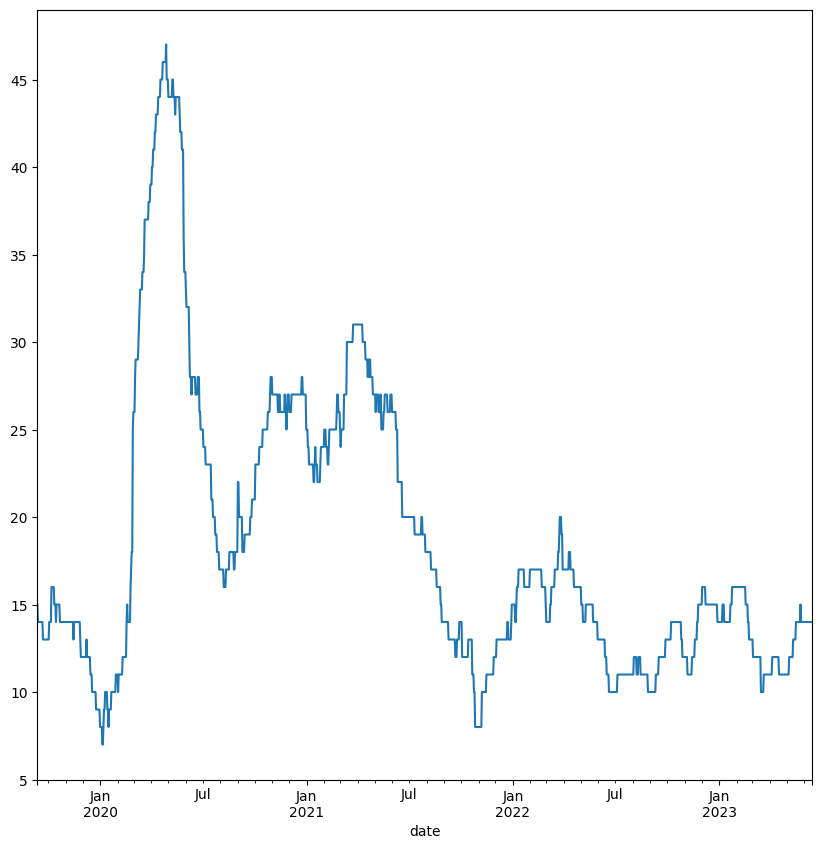

Anzahl Autor:innen mit Edits >= 10: 14

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,731.0
Nadine_Gabel,278.0
Kowalsky,106.0
Julian1492,92.0
AndiSt,72.0
metzgaria,63.0
Annika-Hemlein,63.0
Peter,46.0
Sascha_Lill_95,36.0
BerndF,32.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
wendrock,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Nadine_Gabel,278.0
wdihgefhgflj,17.0
Yummy,6.0
atmflow,5.0
m-kahre,4.0
Tina_B,4.0
silvia-b,3.0
a-pong,3.0
Par145qv,3.0
Adam09,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Yummy,6.0
atmflow,5.0
m-kahre,4.0
Tina_B,4.0
a-pong,3.0
silvia-b,3.0
Par145qv,3.0
Adam09,3.0
Helenita,2.0
HugoBT,2.0


## Fach: Chemie

### Plot Anzahl Autor:innen mit Edits >= 10

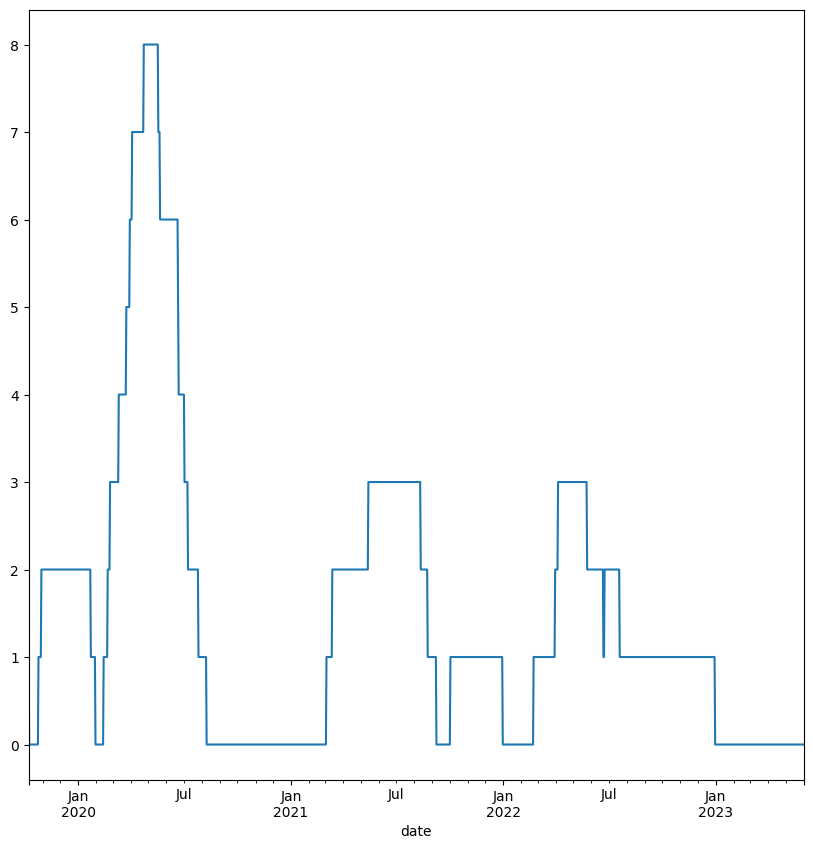

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Jahnavi_Zalki,8.0
AnnaTichs,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Jahnavi_Zalki,8.0
AnnaTichs,2.0


## Fach: Physik

### Plot Anzahl Autor:innen mit Edits >= 10

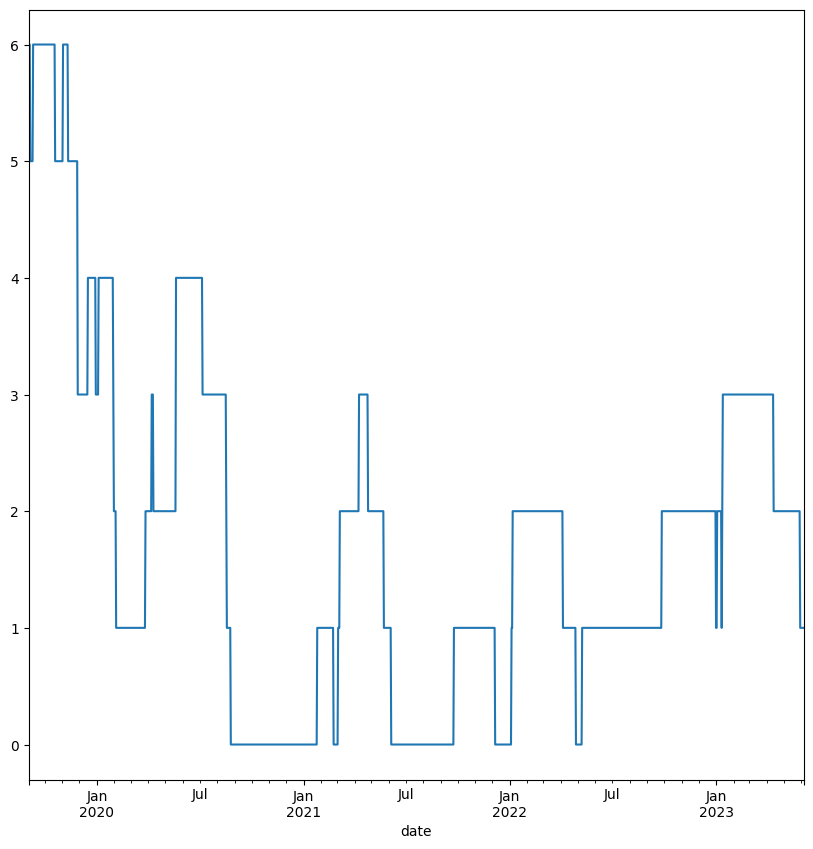

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
uebermario,12.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Felix_Eccardt,5.0
Karin,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Nachhaltigkeit

### Plot Anzahl Autor:innen mit Edits >= 10

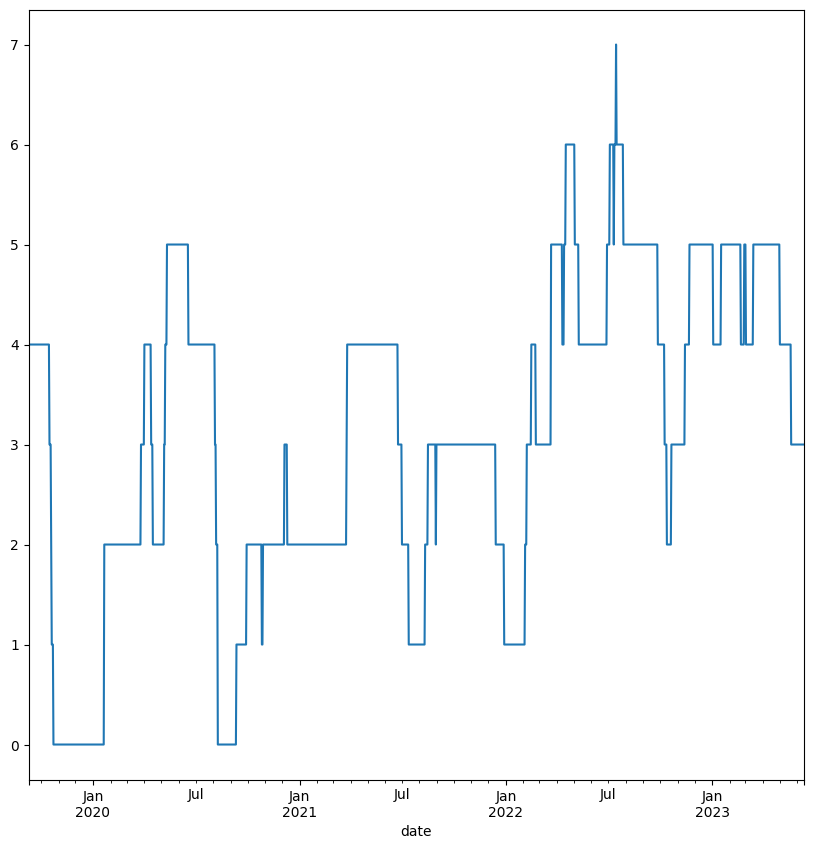

Anzahl Autor:innen mit Edits >= 10: 3

### Autor:innen mit aktuellen Edits >= 10

,edits
Corinna,36.0
Ambi,35.0
Nanami,16.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
konstanze,5.0
Gesine,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Biologie

### Plot Anzahl Autor:innen mit Edits >= 10

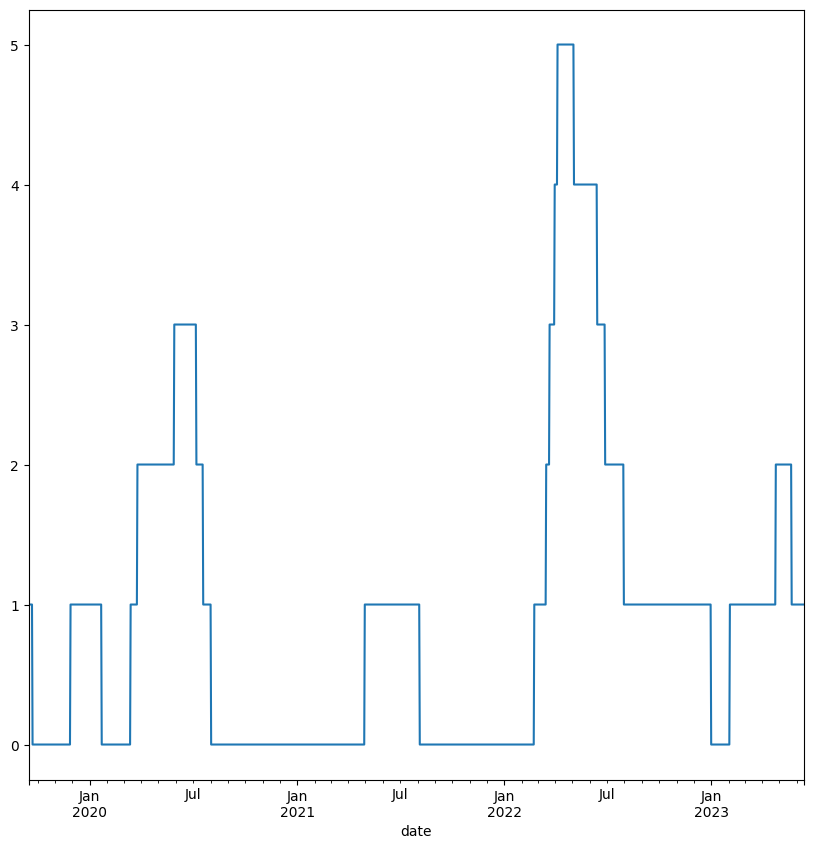

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
Corinna,29.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Alexandra-Wolfram,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
AnnaTichs,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
AnnaTichs,3.0


## Fach: Sandkasten

## Fach: Prüfungsbereich Mathematik

### Plot Anzahl Autor:innen mit Edits >= 10

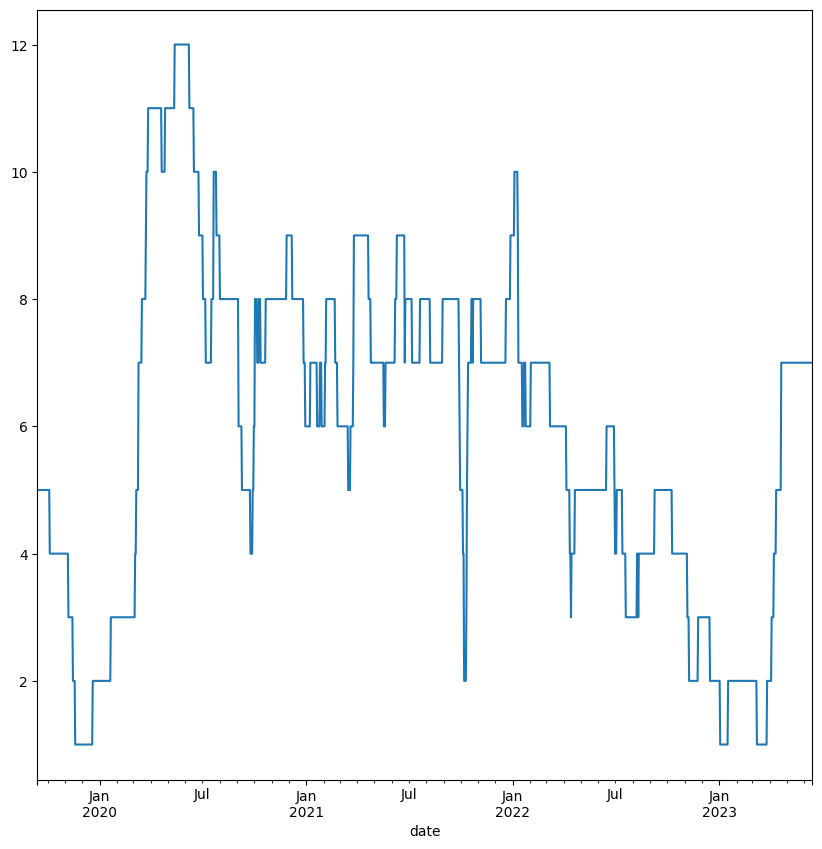

Anzahl Autor:innen mit Edits >= 10: 7

### Autor:innen mit aktuellen Edits >= 10

,edits
Karin,252.0
Kowalsky,210.0
metzgaria,133.0
Felix_Eccardt,59.0
Peter,40.0
BerndF,33.0
ThomasG,23.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Samsumehl,3.0
HannesB,2.0
lejla,2.0
B,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Samsumehl,3.0
HannesB,2.0
lejla,2.0
B,1.0


## Fach: Geographie

### Plot Anzahl Autor:innen mit Edits >= 10

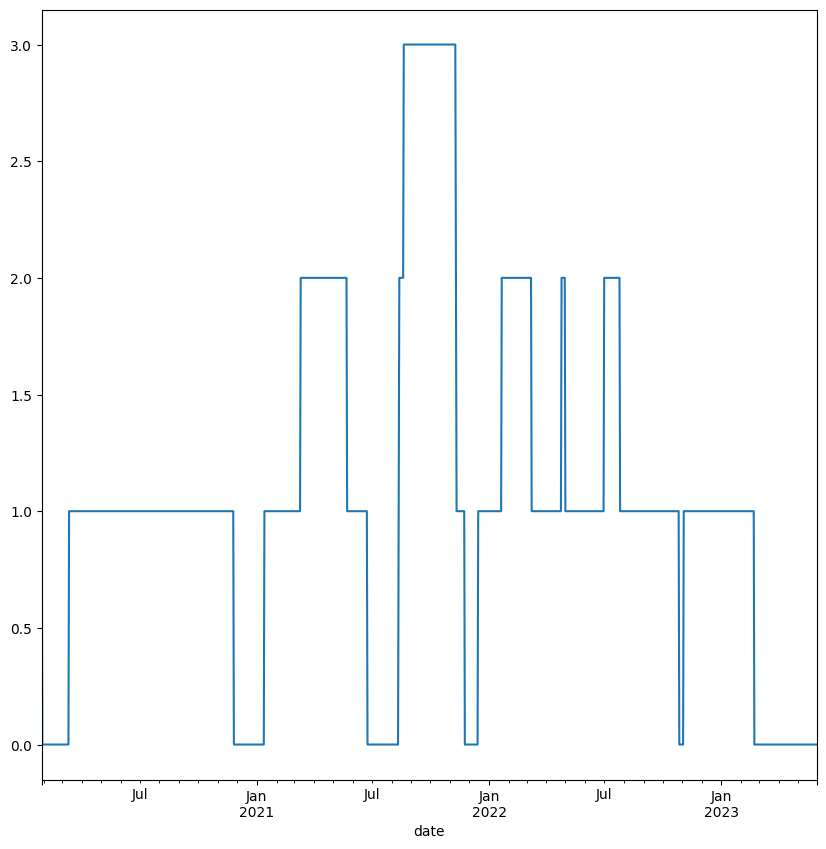

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Geschichte

### Plot Anzahl Autor:innen mit Edits >= 10

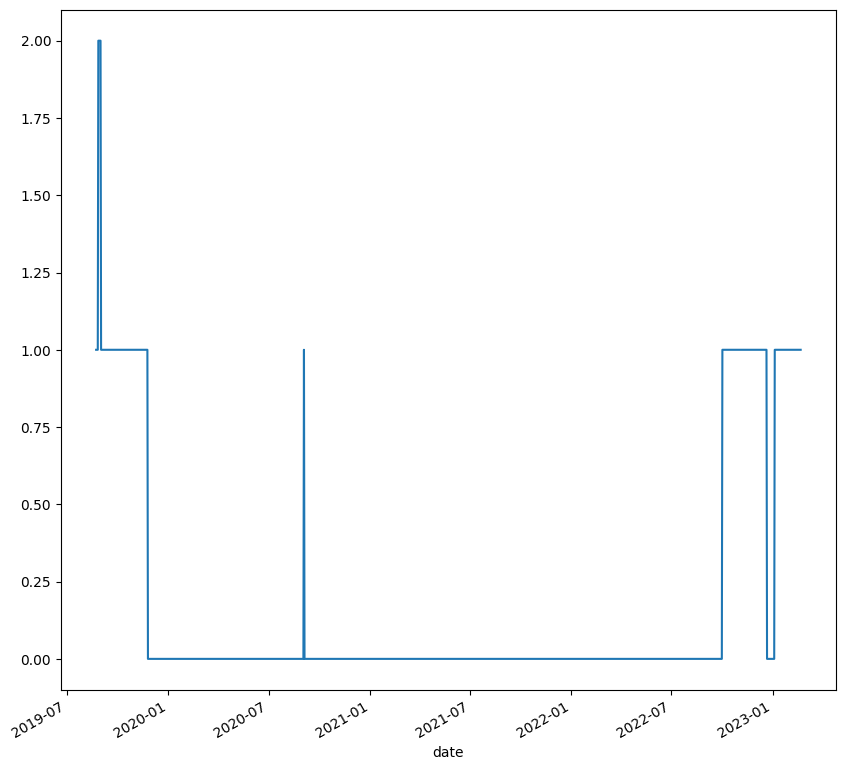

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
raha,25.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
raha,25.0
Corinna,2.0
Karin,1.0
Gesine,1.0
Tina_B,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Corinna,2.0
Karin,1.0
Gesine,1.0
Tina_B,1.0


## Fach: Community

### Plot Anzahl Autor:innen mit Edits >= 10

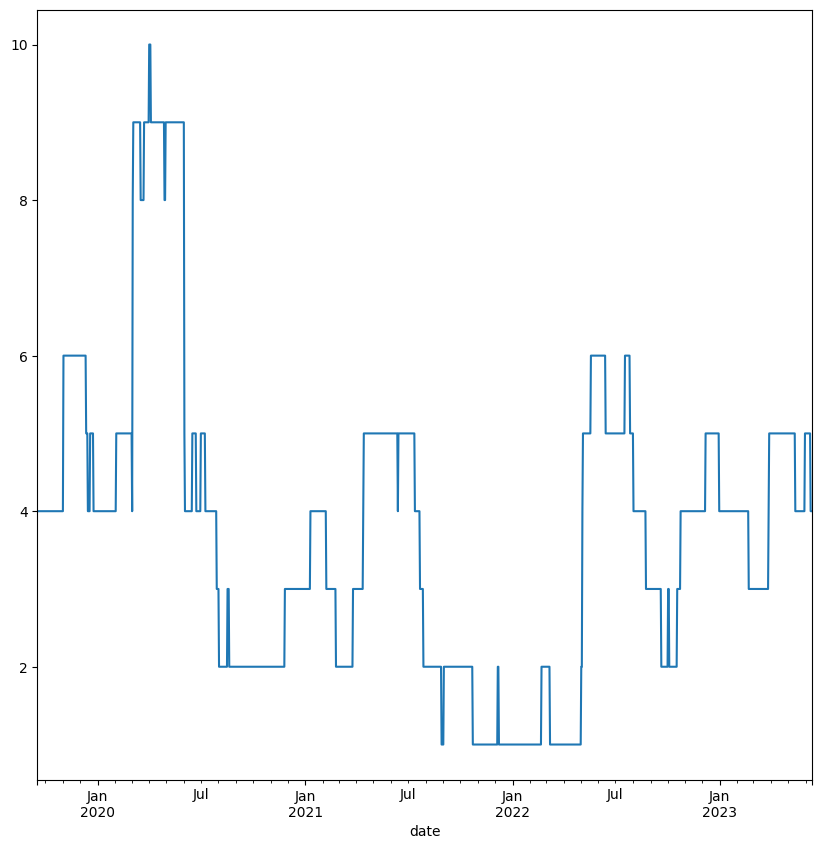

Anzahl Autor:innen mit Edits >= 10: 4

### Autor:innen mit aktuellen Edits >= 10

,edits
Katherin,53.0
LinaMaria,28.0
Helenita,13.0
Peter,12.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Corinna,2.0
Paul_,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Helenita,13.0
sahara91,4.0
Jahnavi_Zalki,3.0
line,2.0
sharmajaanvi770,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
sahara91,4.0
Jahnavi_Zalki,3.0
line,2.0
sharmajaanvi770,1.0


## Fach: Informatik

### Plot Anzahl Autor:innen mit Edits >= 10

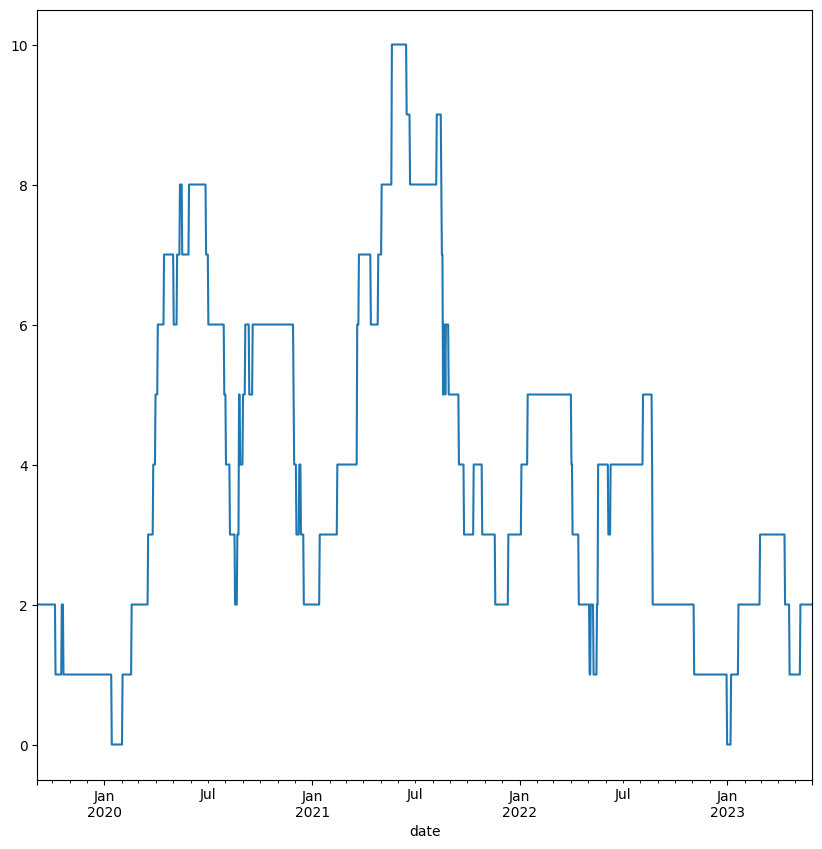

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
hwlang,22.0
opamp,13.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
metzgaria,0.0
dal,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Martin0334,1.0
Lilac,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Martin0334,1.0
Lilac,1.0


## Fach: Englisch

### Plot Anzahl Autor:innen mit Edits >= 10

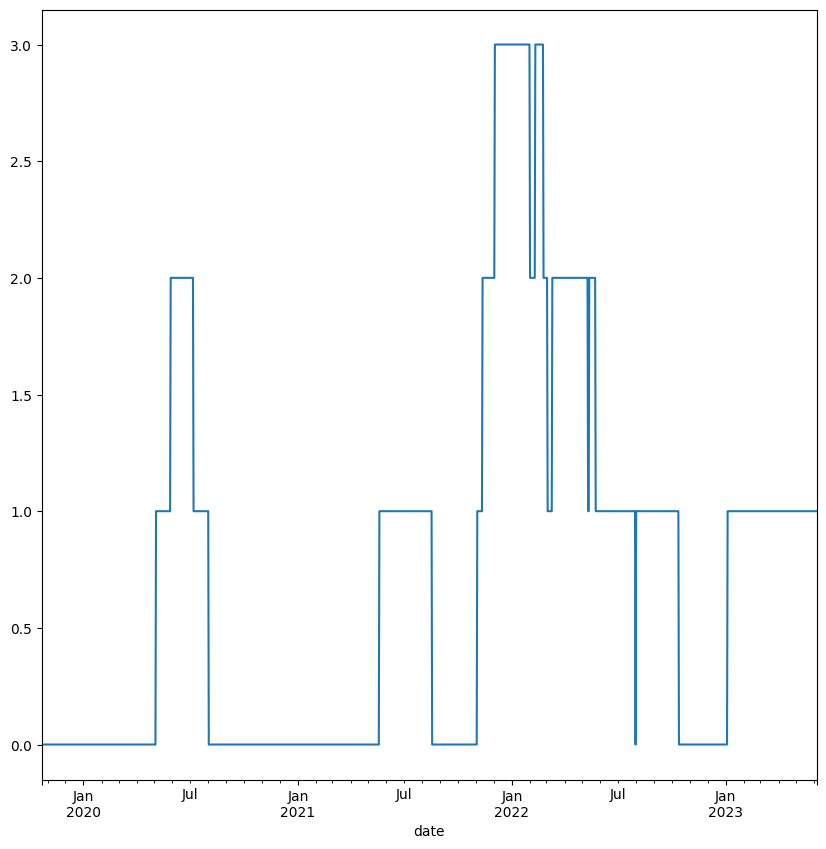

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
Tina_B,15.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


In [17]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie", "Sandkasten", "Prüfungsbereich Mathematik",
               "Geographie", "Geschichte", "Community", "Informatik", "Englisch"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)

In [18]:
def show_no_authors():
    def current_no_authors(d):
        return d[pd.Timestamp.today() - d["date"] < pd.Timedelta("90 days")]["username"].nunique()
    
    def last_year_no_authors(d):
        return d[
            (d["date"] < pd.Timestamp.today() - pd.Timedelta("365 days")) &
            (d["date"] > pd.Timestamp.today() - pd.Timedelta("455 days"))
        ]["username"].nunique()
    
    return event_log.groupby("subject").apply(lambda d: pd.Series({
        "current no authors": current_no_authors(d),
        "last year no authors": last_year_no_authors(d)
    }))

show_no_authors()

,current no authors,last year no authors
subject,,
Biologie,4,6
Chemie,4,8
Community,14,8
Conseils pour apprendre,0,0
Deutsch,2,2
Deutsch als Fremdsprache,1,2
Deutsch als Zweit- und Fremdsprache,0,0
Englisch,3,5
English for Spanish Natives,0,0
